In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    ONE_AND_HALF_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

Text(0, 0.5, 'Position [cm]')

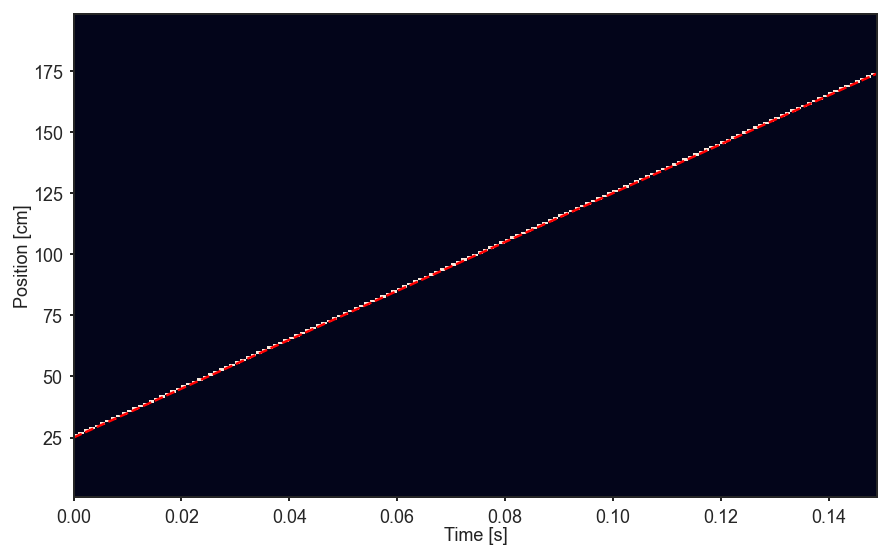

In [3]:
starting_position = 25.0
velocity = 1000  # cm/s

place_bin_edges = np.arange(0.0, 200.0, 1.0)
place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges) / 2
time = np.arange(0, 0.150, 0.001)

likelihood = np.zeros((len(time), len(place_bin_centers)))

true_replay_position = starting_position + velocity * time

p_ind = np.digitize(true_replay_position, place_bin_edges[1:-1])
t_ind = np.arange(len(time))
likelihood[(t_ind, p_ind)] = 1.0

t, p = np.meshgrid(time, place_bin_centers)
plt.pcolormesh(t, p, likelihood.T)
plt.plot(time, true_replay_position, color="red", linestyle="--")
plt.xlabel("Time [s]")
plt.ylabel("Position [cm]")

In [4]:
from skimage.transform import radon


projection_angles = np.arange(-90, 90, 0.5)  # degrees
sinogram = radon(likelihood, theta=projection_angles, circle=False, preserve_range=True)

center_pixel = np.asarray((likelihood.shape[0] // 2, likelihood.shape[1] // 2))

pixels_from_center = np.arange(-sinogram.shape[0] // 2, sinogram.shape[0] // 2)

n_pixels_from_center_ind, projection_angle_ind = np.unravel_index(
    indices=np.argmax(sinogram), shape=sinogram.shape
)

projection_angle = projection_angles[projection_angle_ind]
n_pixels_from_center = pixels_from_center[n_pixels_from_center_ind]

In [5]:
np.max(sinogram)

112.55853963704273

projection angle = 45.0 degrees
projection position = 1 pixels from center


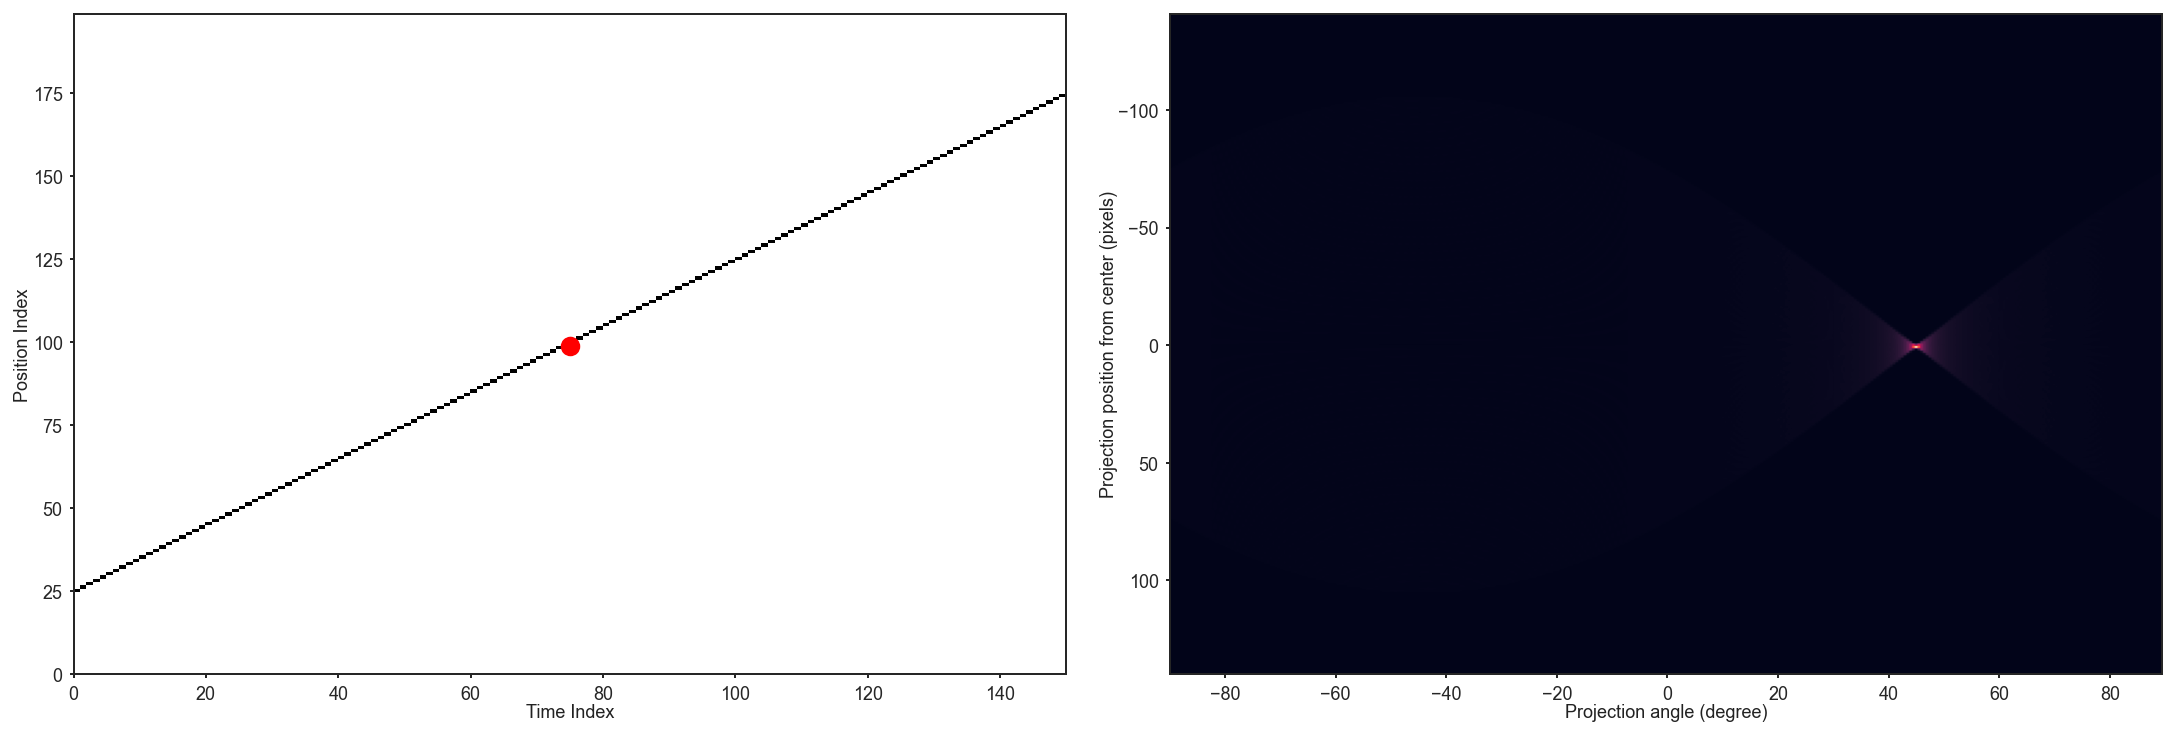

In [6]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(15, 5))
axes[0].pcolormesh(likelihood.T, cmap="bone_r")
axes[0].scatter(center_pixel[0], center_pixel[1], zorder=100, color="red", s=80)
axes[0].set_xlabel("Time Index")
axes[0].set_ylabel("Position Index")

axes[1].imshow(
    sinogram,
    extent=(
        projection_angles.min(),
        projection_angles.max(),
        pixels_from_center.max(),
        pixels_from_center.min(),
    ),
    aspect="auto",
)
axes[1].set_ylabel("Projection position from center (pixels)")
axes[1].set_xlabel("Projection angle (degree)")

print(f"projection angle = {projection_angle} degrees")
print(f"projection position = {n_pixels_from_center} pixels from center")


projection_angle_radians = np.deg2rad(projection_angle)
x1 = center_pixel[0] + n_pixels_from_center * np.cos(projection_angle_radians)
y1 = (center_pixel[1] + n_pixels_from_center) + n_pixels_from_center * np.sin(
    projection_angle_radians
)

axes[0].plot((center_pixel[0], x1), (center_pixel[1] + n_pixels_from_center, y1))

axes[0].scatter(center_pixel[0], center_pixel[1] + n_pixels_from_center)

(-1.1368683772161603e-13, 0.41421356237310647)

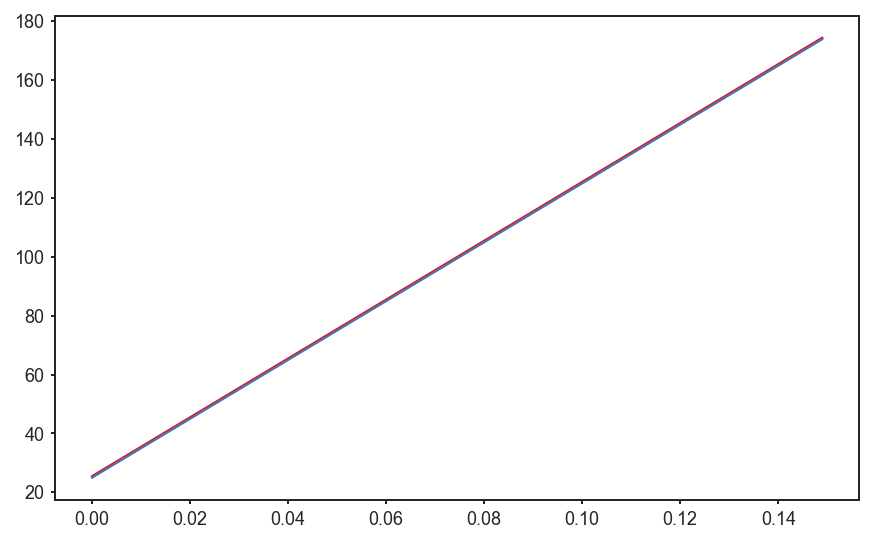

In [9]:
from skimage.transform import radon


def detect_line_with_radon(likelihood, time, place_bin_edges):
    projection_angles = np.arange(-90, 90, 0.5)  # degrees
    sinogram = radon(
        likelihood, theta=projection_angles, circle=False, preserve_range=True
    )

    center_pixel = np.asarray((likelihood.shape[0] // 2, likelihood.shape[1] // 2))

    pixels_from_center = np.arange(-sinogram.shape[0] // 2, sinogram.shape[0] // 2)

    n_pixels_from_center_ind, projection_angle_ind = np.unravel_index(
        indices=np.argmax(sinogram), shape=sinogram.shape
    )

    projection_angle = projection_angles[projection_angle_ind]
    n_pixels_from_center = pixels_from_center[n_pixels_from_center_ind]

    dp = np.mean(np.diff(place_bin_edges))
    dt = np.mean(np.diff(time))

    projection_angle_radians = np.deg2rad(projection_angle)
    estimated_velocity = np.tan(projection_angle_radians) * dp / dt

    time_ind = np.arange(len(time))
    estimated_position = center_pixel[1] + (
        (
            n_pixels_from_center
            - (time_ind - center_pixel[0])
            * np.cos(np.pi / 2 + projection_angle_radians)
        )
        / np.sin(np.pi / 2 + projection_angle_radians)
    )
    estimated_position *= dp

    n_position_bins = likelihood.shape[1]
    score = np.max(sinogram) / n_position_bins

    return estimated_velocity, estimated_position, score


estimated_velocity, estimated_position, score = detect_line_with_radon(
    likelihood, time, place_bin_edges
)

plt.plot(time, estimated_position, color="red")
plt.plot(time, true_replay_position)

estimated_velocity - velocity, estimated_position[0] - starting_position

0.5656208021961946